# Taller 4. Mapeo de QTL por ligamiento
Genética de rasgos complejos 2024-01 - Universidad Nacional de Colombia<br>
Docente Johana Carolina Soto Sedano - jcsotos@unal.edu.co  
 
 
__Hans D. Escobar H.__

In [20]:
# Environment setup

# libraries validation
if (!require("qtl", quietly = TRUE)) {
  stop("Error: missing Rqtl package")
}

# paths validation
data_file_path <- "../Private_Data/data.csv"
if (!file.exists(data_file_path)) {
  stop("Error: file doesn't exist, check the path.")
}


## 1. Explore data

La estructura esperada para importar mapas desde CSV puede ser consultada con:

```R
help(read.cross)
```

Explorando la tabla estructura de la tabla:

In [21]:
read.table(data_file_path, header = TRUE, nrows = 5, sep = ",")


Pheno,Mark1,Mark2,Mark3,Mark4,Mark5,Mark6,Mark7,Mark8,Mark9,⋯,Mark991,Mark992,Mark993,Mark994,Mark995,Mark996,Mark997,Mark998,Mark999,Mark1000
<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
NA,1,1,1,1,1,1,1,1,1,⋯,10,10,10,10,10,10,10,10,10,10
NA,1,2,3,4,5,6,7,8,9,⋯,91,92,93,94,95,96,97,98,99,100
41.04670,0,0,0,1,1,1,0,1,0,⋯,0,0,0,1,0,0,0,1,0,0
-7.06822,1,0,1,1,1,1,1,0,1,⋯,0,1,1,1,0,0,0,1,1,0
32.00474,1,1,0,1,1,1,1,1,1,⋯,0,1,1,0,1,0,0,1,0,1


Es importante que los marcadores usen los mismos códigos para genotipos. Recordemos que en caso de un cruce _backcross_ se tiene dos genotipos, por lo que requiere dos códigos. En el caso de un _intercross_ y en condiciones que se puede diferenciar homocigotos de diferentes alelos, se requieren 3, en caso contrario 5.

Miremos cuantos códigos de genotipo hay en la tabla:

In [22]:
raw_table <- read.table(data_file_path, header = TRUE, sep = ",")
cat("Genotype codes:", unique(as.numeric(raw_table[3, 2:ncol(raw_table)])))


Genotype codes: 0 1

Miremos cuantos datos perdidos hay:

In [23]:
cat("Number of missing values:", sum(is.na(raw_table[3, ])))


Number of missing values: 0

Conociendo esta información podemos cargar nuestros datos para Rqtl:

In [24]:
raw_data <- read.cross(
  format = "csv", file = data_file_path,
  na.strings = "NA", genotype = c("0", "1")
)


 --Read the following data:
	 500  individuals
	 1000  markers
	 1  phenotypes
 --Cross type: bc 


1. En tipo de cruce dice: bc (backcross). ¿Cuál será la relación genotípica? ¿Con SNPs 
como serían los genotipos de los padres?

- La relación es 1:1. $A_1/A_1 : A_1/A_2\space \text{s.t. } A_1 \neq A_2;\space A_1, A_2 \in \{A,G,C,T\}$
- Homocigotos para nucleótidos diferentes. $A_1/A_1,\space A_2/A_2,\space \text{s.t. } A_1 \neq A_2;\space A_1, A_2 \in \{A,G,C,T\}$

In [25]:
summary(raw_data)


    Backcross

    No. individuals:    500 

    No. phenotypes:     1 
    Percent phenotyped: 100 

    No. chromosomes:    10 
        Autosomes:      1 2 3 4 5 6 7 8 9 10 

    Total markers:      1000 
    No. markers:        100 100 100 100 100 100 100 100 100 100 
    Percent genotyped:  100 
    Genotypes (%):      AA:50.0  AB:50.0 

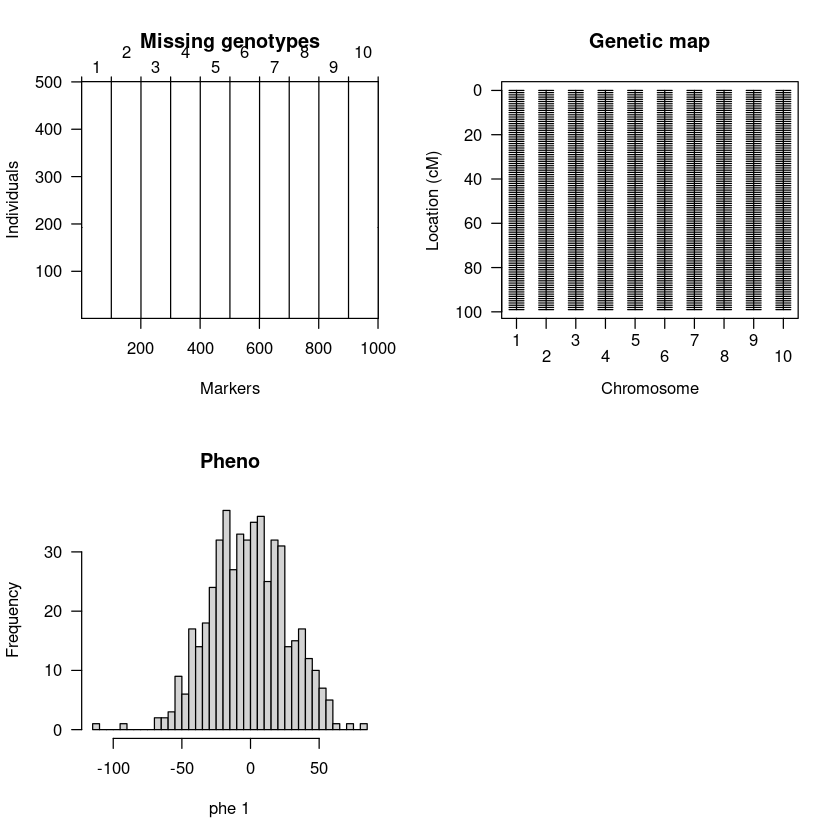

In [121]:
plot(raw_data) # plot.missing plot.map plot.pheno


In [27]:
cat("Markers by chromosome:\n")
print(nmar(raw_data))


Markers by chromosome:
  1   2   3   4   5   6   7   8   9  10 
100 100 100 100 100 100 100 100 100 100 


❗❗❗ Pendiente

2. ¿Observando las gráficas que puede deducir de los datos? 

## 2. Standard interval mapping

- Asume la existencia de un solo QTL
- Asume una grid de posiciones como la posible localización del QTL
- Las distribuciones de probabilidad del genotipo

### Desventajas

- Limitada capacidad de separar QTLs ligados.
- No evalúa interacciones entre QTLs.
- Pueden aparecer falsos LOD muy grandes en regiones con baja densidad de marcadores cuando la distribución del fenotipo es multimodal. 

In [166]:
# La función es scanone. Esta requiere para los métodos em, hk y ehk que
# primero se calculen las probabilidades multipunto

#  Calculate conditional genotype probabilities
corrected_data <- calc.genoprob(raw_data, error.prob = 0.001, map.function = "kosambi")

# Genome scan with a single QTL model
# em: maximum likelihood is performed via the EM algorithm
out_em_kosambi <- scanone(corrected_data, method = "em")


In [63]:
# Registra sólo un pico máximo por cromosoma
summary(out_em_kosambi) # threshold=value


,chr,pos,lod
,<fct>,<dbl>,<dbl>
Mark29,1,29,6.586314
Mark149,2,49,3.676134
Mark262,3,62,5.378991
Mark329,4,29,5.428027
Mark485,5,85,1.443209
Mark503,6,3,2.784209
Mark666,7,66,6.354468
Mark799,8,99,1.456354
Mark885,9,85,1.115737


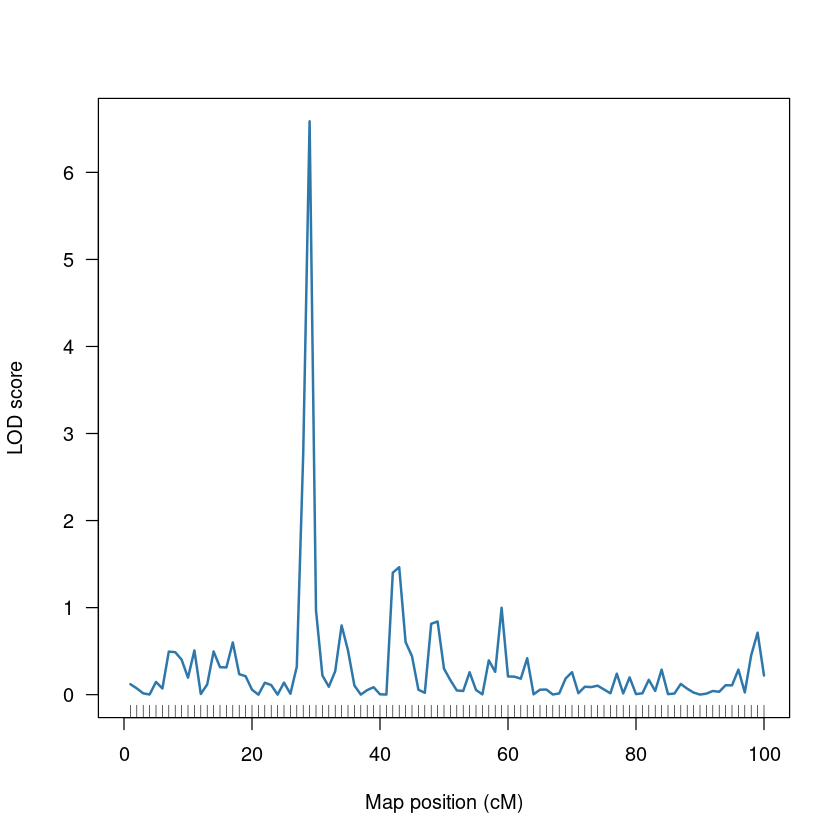

In [122]:
# Mostrando solo el cromosoma con el máximo LOD
plot(out_em_kosambi, chr = max(out_em_kosambi)$chr, ylab = "LOD score", col = "#2e77ab")


### Determinando el umbral de significancia

Para esto se emplea la distribución nula del máximo LOD de todo el genoma. Está depende de factores tales como:

- Tipo de cruce (back o inter).
- Tamaño del genoma en cM.
- Tamaño de la muestra.
- Numero de marcadores typed???
- Patron de genotipos perdidos.
- Distribución del fenotipo.

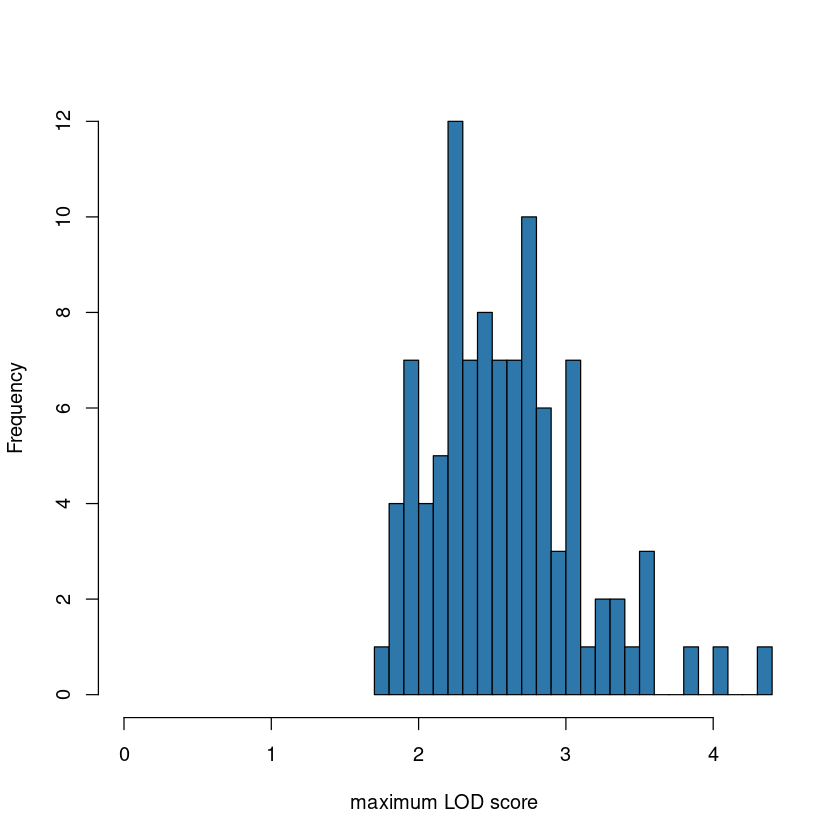

In [123]:
# Para determinarlo por permutaciones,
# primero se obtiene las máximas verosimilitudes de cada permutación
max_lod_distribution <- scanone(corrected_data, n.perm = 100, verbose = FALSE)
plot(max_lod_distribution, col = "#2e77ab")


In [168]:
# Obtener el umbral de significancia
threshold_lod <- summary(max_lod_distribution, alpha = 0.05)
print(threshold_lod)

# Tabla mostrando solo los cromosomas con valores superiores al umbral

out_em_significant <- summary(
  out_em_kosambi,
  perms = max_lod_distribution, alpha = 0.05, pvalues = TRUE
)

out_em_significant


LOD thresholds (100 permutations)
    lod
5% 3.56


,chr,pos,lod,pval
,<fct>,<dbl>,<dbl>,<dbl>
Mark29,1,29,6.586314,0.00
Mark149,2,49,3.676134,0.03
Mark262,3,62,5.378991,0.00
Mark329,4,29,5.428027,0.00
Mark666,7,66,6.354468,0.00


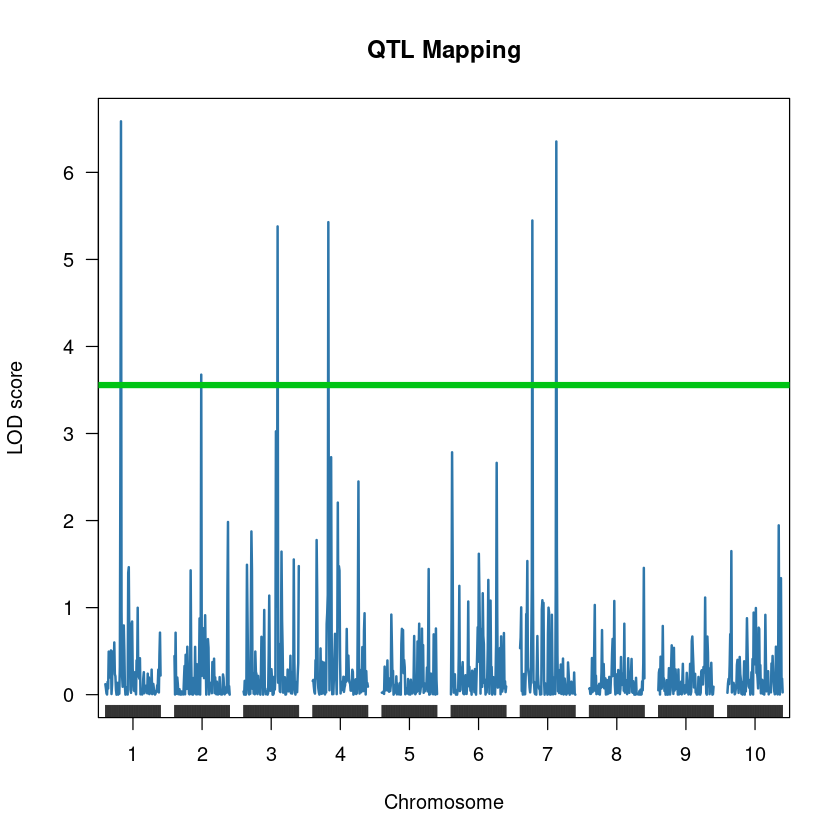

In [126]:
plot(out_em_kosambi, ylab = "LOD score", col = "#2e77ab")
abline(h = threshold_lod[1], col = "#00c414", lwd = 5)
title(main = "QTL Mapping")


❗❗❗ Pendiente

3. ¿Cuáles son QTL estadísticamente significativos? ¿Cuál es su criterio?
4. Obtengan las gráficas de varios cromosomas

### Estimación del intervalo de localización del QTL

Mayormente se emplean dos métodos:

- Intervalos soportados por LOD (lodint)
- Intervalo creíble (bayesint)

In [165]:
# Intervalo dentro del intervalo de 1.5 LOD entorno al pico del cromosoma
lodint(out_em_kosambi,
  chr = as.numeric(max(out_em_kosambi)$chr),
  drop = 1.5,
  expandtomarkers = TRUE
)


,chr,pos,lod
,<fct>,<dbl>,<dbl>
Mark28,1,28,2.7604808
Mark29,1,29,6.5863137
Mark30,1,30,0.9685166


### Efectos del QTL

La proporción de la varianza fenotípica explicada por el QTL o su heredabilidad está dada por:

$$h^2 = \frac{var\{\mathbb{E}(\text{phenotype}|\text{QTL genotype})\}}{var(\text{phenotype})}$$

  QTL object containing genotype probabilities. 

     name chr pos n.gen
Q1 1@29.0   1  29     2
Q2 2@49.0   2  49     2
Q3 3@62.0   3  62     2
Q4 4@29.0   4  29     2
Q5 7@66.0   7  66     2


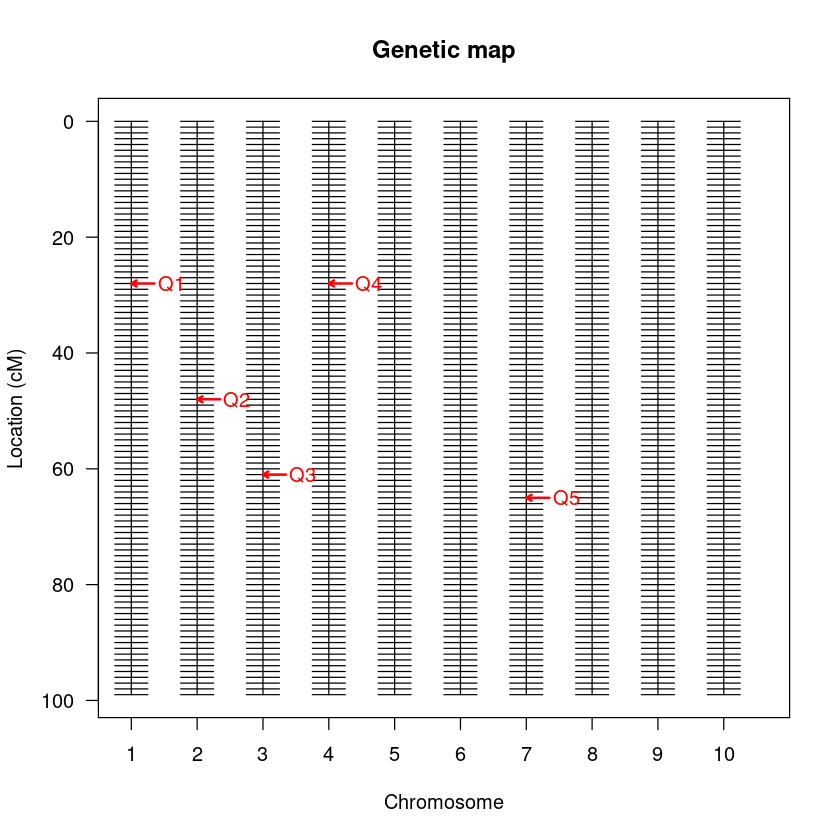

In [184]:
# Especifica el conjunto de QTL putativos a considerar
sim_qtl <- makeqtl(
  corrected_data,
  chr = out_em_significant$chr, pos = out_em_significant$pos, what = "prob"
)
print(sim_qtl)
plot(sim_qtl)


In [186]:
# Ajusta el modelo de QTL definido. Permite agregar
# interacciones entre QTL y covariables

sim_fitted_model <- fitqtl(
  corrected_data,
  qtl = sim_qtl, formula = "y~Q1 + Q2 + Q3 + Q4 + Q5",
  method = "hk", get.ests = TRUE
)
summary(sim_fitted_model)



		fitqtl summary

Method: Haley-Knott regression 
Model:  normal phenotype
Number of observations : 500 

Full model result
----------------------------------  
Model formula: y ~ Q1 + Q2 + Q3 + Q4 + Q5 

       df        SS         MS      LOD     %var Pvalue(Chi2) Pvalue(F)
Model   5  87842.14 17568.4279 28.46568 23.06264            0         0
Error 494 293042.89   593.2042                                         
Total 499 380885.03                                                    


Drop one QTL at a time ANOVA table: 
----------------------------------  
       df Type III SS   LOD  %var F value Pvalue(Chi2) Pvalue(F)    
1@29.0  1       17974 6.463 4.719   30.30            0  5.96e-08 ***
2@49.0  1       11584 4.209 3.041   19.53            0  1.22e-05 ***
3@62.0  1       18368 6.601 4.822   30.96            0  4.32e-08 ***
4@29.0  1       13976 5.058 3.669   23.56            0  1.63e-06 ***
7@66.0  1       19397 6.959 5.093   32.70            0  1.87e-08 ***
---
Signif. code